# やること

- 10 周期分で学習
- train, test, valid に分割


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim

# 乱数固定用の処理
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


In [2]:
class BuckConverterCell(nn.Module):
    def __init__(
        self,
        L_init: float = 200e-6,
        C_init: float = 100e-6,
        R_init: float = 8.0,
    ) -> None:
        super().__init__()
        # パラメータを対数空間で学習（正の値を保証）
        self.log_L = nn.Parameter(torch.log(torch.tensor(L_init)))
        self.log_C = nn.Parameter(torch.log(torch.tensor(C_init)))
        self.log_R = nn.Parameter(torch.log(torch.tensor(R_init)))

    def forward(
        self,
        h: torch.Tensor,
        vs: torch.Tensor,
        u: torch.Tensor,
        dt: torch.Tensor,
    ) -> torch.Tensor:
        # h: [iL, vC]

        iL = h[:, 0]
        vC = h[:, 1]
        vp = vs * u

        # パラメータを指数関数で変換（正の値を保証）
        L = torch.exp(self.log_L)
        C = torch.exp(self.log_C)
        R = torch.exp(self.log_R)

        # オイラー法
        iL_next = iL + (dt / L) * (vp - vC)
        vC_next = vC + (dt / C) * (iL - vC / R)

        return torch.stack([iL_next, vC_next], dim=1)

    def get_params(self) -> dict:
        return {
            "L": torch.exp(self.log_L).item(),
            "C": torch.exp(self.log_C).item(),
            "R": torch.exp(self.log_R).item(),
            "log_L": self.log_L.item(),
            "log_C": self.log_C.item(),
            "log_R": self.log_R.item(),
        }

# BuckConverterCell を使ってシミュレーションデータを作成


len(t)=200001
len(dt)=200000
len(u)=200000
len(vs)=200000


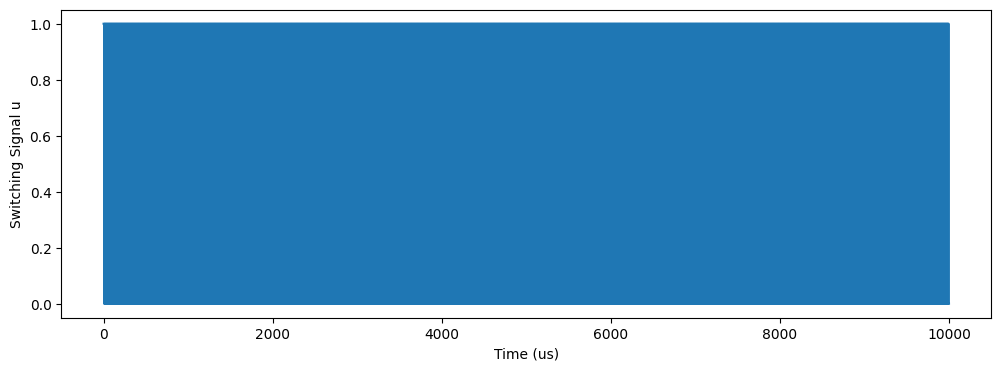

In [3]:
# 真値パラメータ（すべてのデータセットで共通）
L_true: float = 100e-6
C_true: float = 48e-6
R_true: float = 10

Vin: float = 10
Vref: float = 6
duty: float = Vref / Vin
f_sw: float = 1e5  # スイッチング周波数
T: float = 1 / f_sw  # 1周期の実時間
points_per_cycle: int = 200  # 1周期あたりのプロット数
cycles: int = 1000  # 周期数

t: np.ndarray = np.linspace(0, cycles * T, cycles * points_per_cycle + 1)
dt: np.ndarray = np.diff(t)

# スイッチング信号
duty_phase = (t[:-1] % T) / T
u = (duty_phase < duty).astype(int)

# 入力電圧
vs = np.ones(len(t) - 1) * Vin

print(f"{len(t)=}")
print(f"{len(dt)=}")
print(f"{len(u)=}")
print(f"{len(vs)=}")

# プロット
plt.figure(figsize=(12, 4))
plt.step(t[:-1] * 1e6, u, where="post")
plt.xlabel("Time (us)")
plt.ylabel("Switching Signal u")
plt.show()

In [4]:
# モデルを作成
model_true = BuckConverterCell(L_init=L_true, C_init=C_true, R_init=R_true)

# numpy配列をテンソルに変換
vs_tensor = torch.tensor(vs, dtype=torch.float32)
u_tensor = torch.tensor(u, dtype=torch.float32)
dt_tensor = torch.tensor(dt, dtype=torch.float32)

il_list = []
vc_list = []

# シミュレーション実行
with torch.no_grad():
    h_current: torch.Tensor = torch.zeros(1, 2)  # [i_L=0, v_C=0]
    for j in range(len(t) - 1):
        # 現在の状態を保存
        il_list.append(h_current[0, 0].item())  # i_L
        vc_list.append(h_current[0, 1].item())  # v_C

        h_current = model_true(h_current, vs_tensor[j], u_tensor[j], dt_tensor[j])


iL = torch.tensor(np.array(il_list), dtype=torch.float32)
vC = torch.tensor(np.array(vc_list), dtype=torch.float32)

print(iL.shape)
print(vC.shape)


torch.Size([200000])
torch.Size([200000])


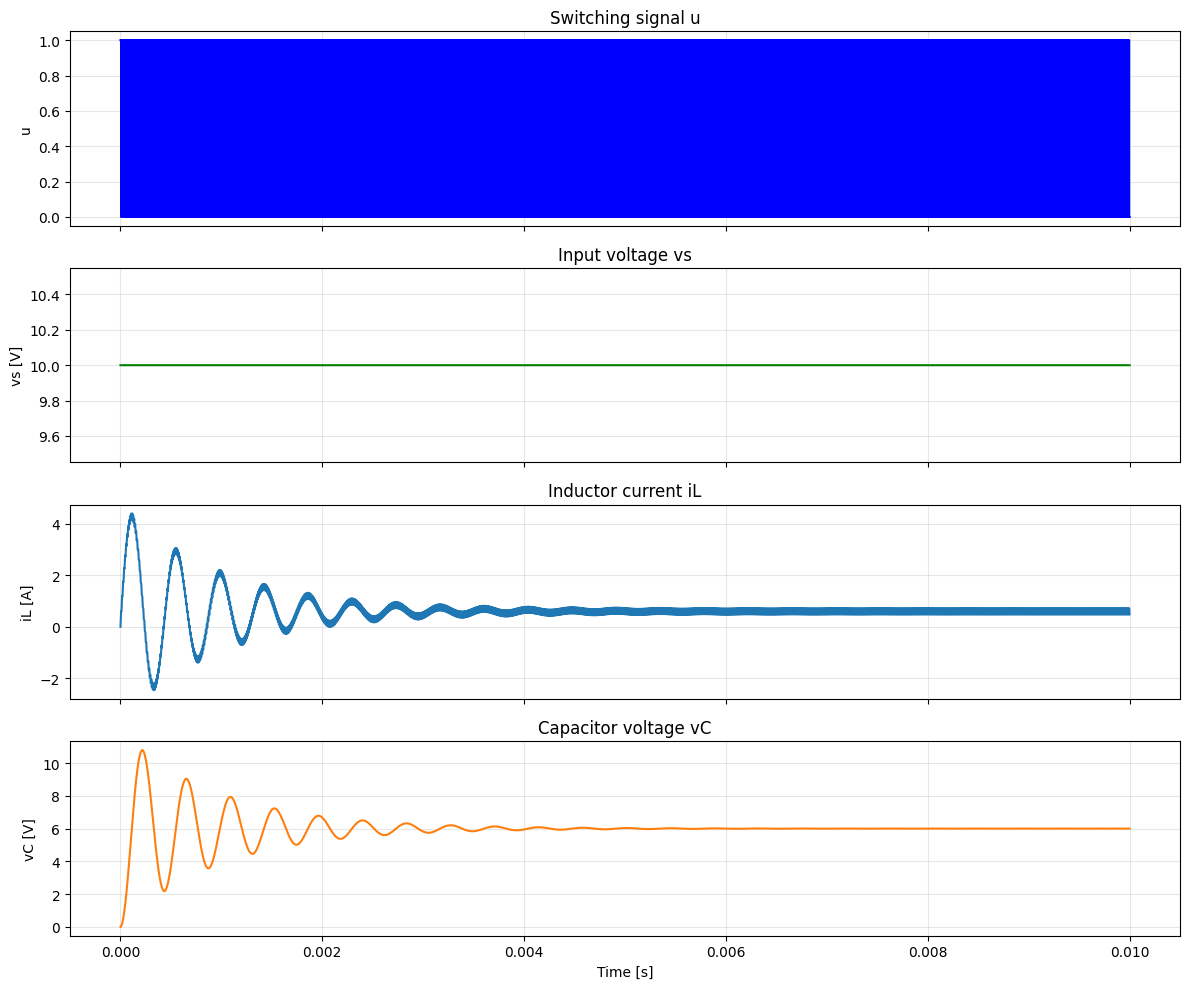

In [5]:
fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# 1: u (switching signal)
axs[0].step(t[:-1], u, where="post", color="blue", linewidth=1.5)
axs[0].set_ylabel("u")
axs[0].grid(True, alpha=0.3)
axs[0].set_title("Switching signal u")

# 2: vs (input voltage)
axs[1].plot(t[:-1], vs, color="green", linewidth=1.5)
axs[1].set_ylabel("vs [V]")
axs[1].grid(True, alpha=0.3)
axs[1].set_title("Input voltage vs")

# 3: iL (inductor current)
axs[2].plot(t[:-1], iL, color="tab:blue", linewidth=1.5)
axs[2].set_ylabel("iL [A]")
axs[2].grid(True, alpha=0.3)
axs[2].set_title("Inductor current iL")

# 4: vC (capacitor voltage)
axs[3].plot(t[:-1], vC, color="tab:orange", linewidth=1.5)
axs[3].set_ylabel("vC [V]")
axs[3].set_xlabel("Time [s]")
axs[3].grid(True, alpha=0.3)
axs[3].set_title("Capacitor voltage vC")

plt.tight_layout()
plt.show()


# 前処理


In [6]:
# 定常の10周期分
t_10 = t[-points_per_cycle * 10 - 1 :]
dt_10 = dt[-points_per_cycle * 10 :]
u_10 = u[-points_per_cycle * 10 :]
vs_10 = vs[-points_per_cycle * 10 :]
iL_10 = iL[-points_per_cycle * 10 :]
vC_10 = vC[-points_per_cycle * 10 :]

# numpy配列をテンソルに変換
dt_10_tensor = torch.tensor(dt_10, dtype=torch.float32)
u_10_tensor = torch.tensor(u_10, dtype=torch.float32)
vs_10_tensor = torch.tensor(vs_10, dtype=torch.float32)

# train
train_ratio = 0.3
train_len = int(len(t_10) * train_ratio)

t_train = t_10[:train_len]
dt_train = dt_10_tensor[:train_len]
u_train = u_10_tensor[:train_len]
vs_train = vs_10_tensor[:train_len]
iL_train = iL_10[:train_len]
vC_train = vC_10[:train_len]

# test
test_ratio = 0.3
test_len = int(len(t_10) * test_ratio)

t_test = t_10[train_len : train_len + test_len]
dt_test = dt_10_tensor[train_len : train_len + test_len]
iL_test = iL_10[train_len : train_len + test_len]
vC_test = vC_10[train_len : train_len + test_len]
u_test = u_10_tensor[train_len : train_len + test_len]
vs_test = vs_10_tensor[train_len : train_len + test_len]

# valid
t_valid = t_10[train_len + test_len :]
dt_valid = dt_10_tensor[train_len + test_len :]
iL_valid = iL_10[train_len + test_len :]
vC_valid = vC_10[train_len + test_len :]
u_valid = u_10_tensor[train_len + test_len :]
vs_valid = vs_10_tensor[train_len + test_len :]


print(f"{len(dt_train)=}")
print(f"{len(dt_test)=}")
print(f"{len(dt_valid)=}")


len(dt_train)=600
len(dt_test)=600
len(dt_valid)=800


# 学習


In [7]:
# 学習パラメータ
L_init = 200e-6
C_init = 100e-6
R_init = 8.0

# 異なるパラメータに異なる学習率を設定
lr_L = 1e-2
lr_C = 5e-2
lr_R = 2e-2

epochs = 1000

model = BuckConverterCell(L_init=L_init, C_init=C_init, R_init=R_init)

optimizer = optim.Adam(
    [
        {"params": [model.log_L], "lr": lr_L},
        {"params": [model.log_C], "lr": lr_C},
        {"params": [model.log_R], "lr": lr_R},
    ]
)

loss_fn = nn.MSELoss()

# 損失履歴を保存
train_loss_history = []
valid_loss_history = []
param_history = {"L": [], "C": [], "R": [], "log_L": [], "log_C": [], "log_R": []}

# 学習データの準備 - 次ステップ予測のためのペアを作成
h_seq_train = torch.stack([iL_train[:-1], vC_train[:-1]], dim=1)  # 現在の状態
h_target_train = torch.stack([iL_train[1:], vC_train[1:]], dim=1)  # 次時刻の状態

# 検証データの準備
h_seq_valid = torch.stack([iL_valid[:-1], vC_valid[:-1]], dim=1)
h_target_valid = torch.stack([iL_valid[1:], vC_valid[1:]], dim=1)

# 学習ループ
for epoch in range(epochs):
    # 学習モード
    model.train()
    optimizer.zero_grad()
    h_pred_train = model(h_seq_train, vs_train[:-1], u_train[:-1], dt_train[:-1])
    train_loss = loss_fn(h_pred_train, h_target_train)
    train_loss.backward()
    optimizer.step()

    train_loss_history.append(train_loss.item())

    # 検証モード（勾配計算なし）
    model.eval()
    with torch.no_grad():
        h_pred_valid = model(h_seq_valid, vs_valid[:-1], u_valid[:-1], dt_valid[:-1])
        valid_loss = loss_fn(h_pred_valid, h_target_valid)
        valid_loss_history.append(valid_loss.item())

    # パラメータの履歴を保存
    params = model.get_params()
    param_history["L"].append(params["L"])
    param_history["C"].append(params["C"])
    param_history["R"].append(params["R"])
    param_history["log_L"].append(params["log_L"])
    param_history["log_C"].append(params["log_C"])
    param_history["log_R"].append(params["log_R"])

    if epoch % 50 == 0:
        print(
            f"Epoch {epoch}: Train Loss={train_loss.item():.6e}, "
            f"Valid Loss={valid_loss.item():.6e}  "
            f"L={params['L'] * 1e6:.1f}µH (true={L_true * 1e6:.1f})  "
            f"C={params['C'] * 1e6:.1f}µF (true={C_true * 1e6:.1f})  "
            f"R={params['R']:.2f}Ω (true={R_true:.1f})"
        )
else:
    print("学習完了")
    print(
        f"Epoch {epoch}: Train Loss={train_loss.item():.6e}, "
        f"Valid Loss={valid_loss.item():.6e}  "
        f"L={params['L'] * 1e6:.1f}µH (true={L_true * 1e6:.1f})  "
        f"C={params['C'] * 1e6:.1f}µF (true={C_true * 1e6:.1f})  "
        f"R={params['R']:.2f}Ω (true={R_true:.1f})"
    )


Epoch 0: Train Loss=7.535161e-07, Valid Loss=7.383213e-07  L=198.0µH (true=100.0)  C=101.5µF (true=48.0)  R=8.12Ω (true=10.0)
Epoch 50: Train Loss=1.134205e-07, Valid Loss=1.057701e-07  L=123.0µH (true=100.0)  C=95.3µF (true=48.0)  R=10.10Ω (true=10.0)
Epoch 100: Train Loss=4.581259e-10, Valid Loss=4.732972e-10  L=99.2µH (true=100.0)  C=72.2µF (true=48.0)  R=10.01Ω (true=10.0)
Epoch 150: Train Loss=7.520483e-11, Valid Loss=7.271634e-11  L=100.1µH (true=100.0)  C=57.5µF (true=48.0)  R=10.00Ω (true=10.0)
Epoch 200: Train Loss=7.720138e-12, Valid Loss=7.280135e-12  L=100.0µH (true=100.0)  C=50.7µF (true=48.0)  R=10.00Ω (true=10.0)
Epoch 250: Train Loss=3.902892e-13, Valid Loss=3.780550e-13  L=100.0µH (true=100.0)  C=48.6µF (true=48.0)  R=10.00Ω (true=10.0)
Epoch 300: Train Loss=3.055690e-14, Valid Loss=3.087615e-14  L=100.0µH (true=100.0)  C=48.1µF (true=48.0)  R=10.00Ω (true=10.0)
Epoch 350: Train Loss=4.934654e-15, Valid Loss=6.118315e-15  L=100.0µH (true=100.0)  C=48.0µF (true=48.0)  R

# 結果


In [8]:
# テストデータでの評価
model.eval()
with torch.no_grad():
    h_seq_test = torch.stack([iL_test[:-1], vC_test[:-1]], dim=1)
    h_target_test = torch.stack([iL_test[1:], vC_test[1:]], dim=1)
    h_pred_test = model(h_seq_test, vs_test[:-1], u_test[:-1], dt_test[:-1])
    test_loss = loss_fn(h_pred_test, h_target_test)

print("\n=== 評価結果 ===")
print(f"Train Loss: {train_loss_history[-1]:.6e}")
print(f"Valid Loss: {valid_loss_history[-1]:.6e}")
print(f"Test Loss: {test_loss.item():.6e}")

# 最終パラメータ

final_params = model.get_params()
print("\n=== 推定パラメータ ===")
print(f"L: {final_params['L'] * 1e6:.2f} µH (真値: {L_true * 1e6:.2f} µH)")
print(f"C: {final_params['C'] * 1e6:.2f} µF (真値: {C_true * 1e6:.2f} µF)")
print(f"R: {final_params['R']:.2f} Ω (真値: {R_true:.2f} Ω)")


=== 評価結果 ===
Train Loss: 1.897944e-16
Valid Loss: 5.691456e-16
Test Loss: 3.795888e-16

=== 推定パラメータ ===
L: 100.00 µH (真値: 100.00 µH)
C: 48.00 µF (真値: 48.00 µF)
R: 10.00 Ω (真値: 10.00 Ω)


In [9]:
# シミュレーションしてみる
il_sim = []
vc_sim = []
with torch.no_grad():
    # iL_10, vC_10の初期値を使って初期状態を設定
    h_current = torch.tensor([[iL_10[0], vC_10[0]]], dtype=torch.float32)
    # 定常状態の10周期分のデータを使う（vs_10_tensor, u_10_tensor, dt_10_tensor）
    for i in range(len(t_10) - 1):
        il_sim.append(h_current[0, 0].item())
        vc_sim.append(h_current[0, 1].item())
        h_next = model(h_current, vs_10_tensor[i], u_10_tensor[i], dt_10_tensor[i])
        h_current = h_next


print(len(il_sim))
print(len(vc_sim))


2000
2000


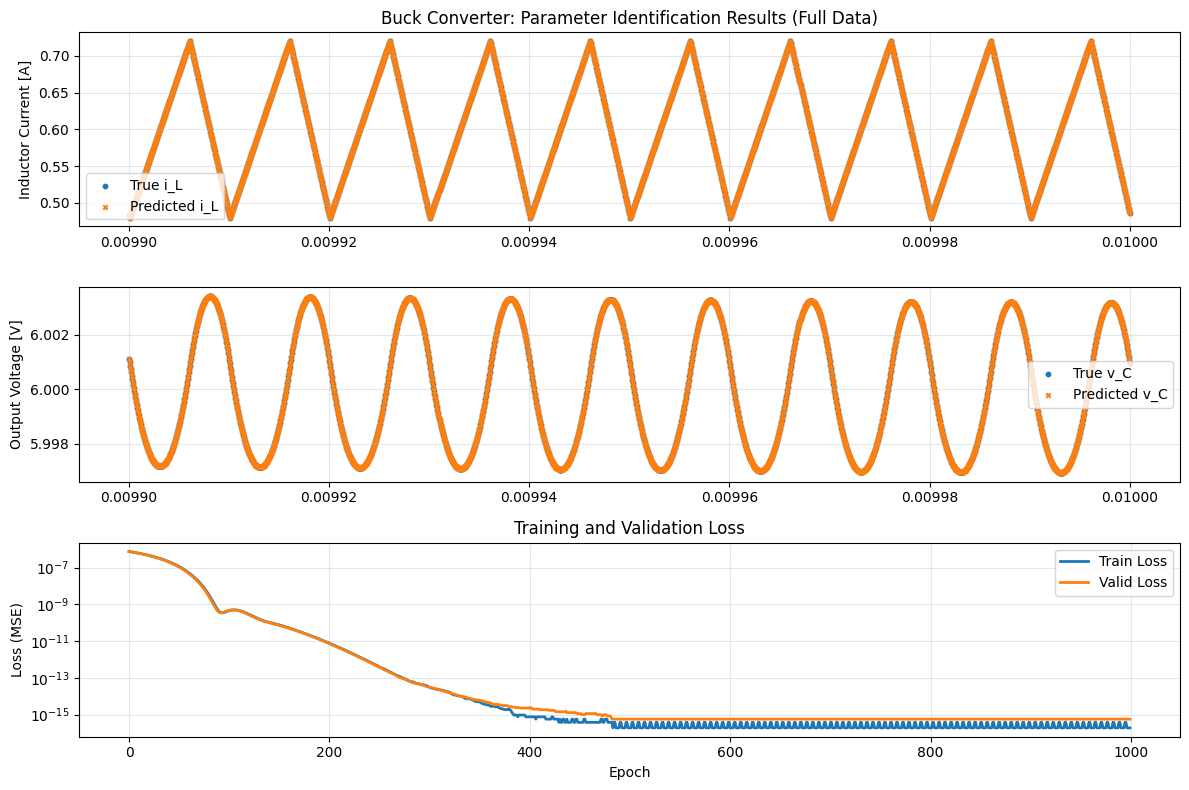

In [10]:
# 全データでのシミュレーション結果（点表示）
fig, axes = plt.subplots(3, 1, figsize=(12, 8))
time = t_10[1:]

# インダクタ電流（線ではなく点で表示）
axes[0].scatter(time, iL_10, label="True i_L", s=10)
axes[0].scatter(time, il_sim, label="Predicted i_L", s=10, marker="x")
axes[0].set_ylabel("Inductor Current [A]")
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_title("Buck Converter: Parameter Identification Results (Full Data)")

# キャパシタ電圧（線ではなく点で表示）
axes[1].scatter(time, vC_10, label="True v_C", s=10)
axes[1].scatter(time, vc_sim, label="Predicted v_C", s=10, marker="x")
axes[1].set_ylabel("Output Voltage [V]")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 損失関数の履歴は線のまま（点はわかりにくいため）
axes[2].semilogy(train_loss_history, label="Train Loss", linewidth=2)
axes[2].semilogy(valid_loss_history, label="Valid Loss", linewidth=2)
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Loss (MSE)")
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].set_title("Training and Validation Loss")

plt.tight_layout()
plt.show()


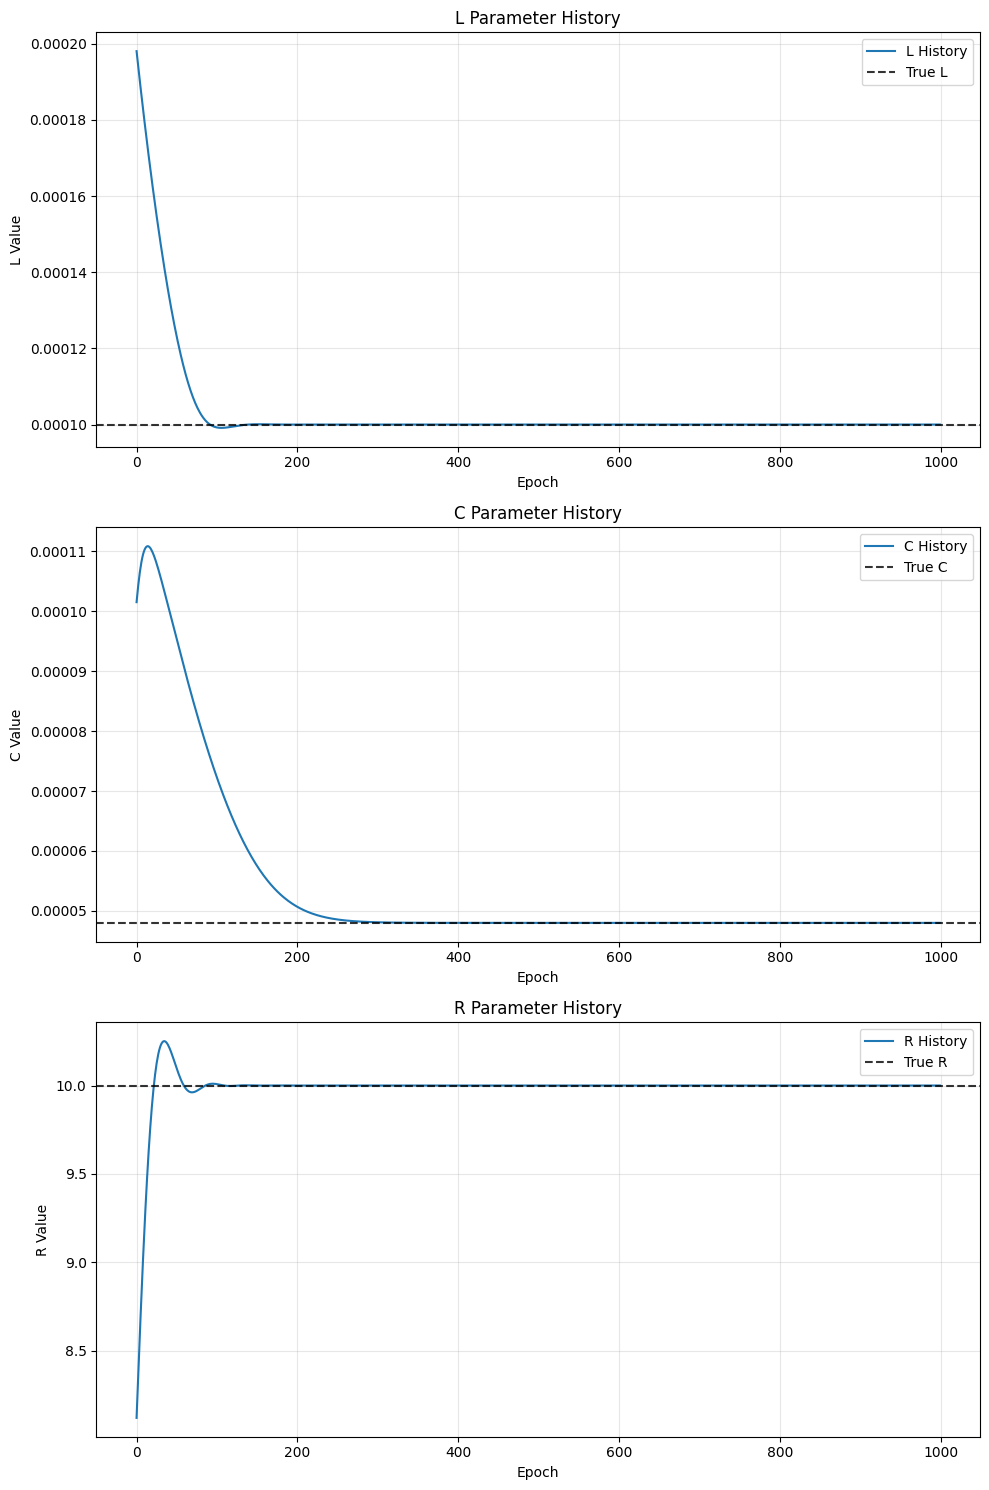

In [11]:
# 各パラメータの遷移
plt.figure(figsize=(10, 15))

# Plot L parameter
plt.subplot(3, 1, 1)
plt.plot(param_history["L"], label="L History")
plt.axhline(y=L_true, color="k", linestyle="--", alpha=0.8, label="True L")
plt.xlabel("Epoch")
plt.ylabel("L Value")
plt.title("L Parameter History")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot C parameter
plt.subplot(3, 1, 2)
plt.plot(param_history["C"], label="C History")
plt.axhline(y=C_true, color="k", linestyle="--", alpha=0.8, label="True C")
plt.xlabel("Epoch")
plt.ylabel("C Value")
plt.title("C Parameter History")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot R parameter
plt.subplot(3, 1, 3)
plt.plot(param_history["R"], label="R History")
plt.axhline(y=R_true, color="k", linestyle="--", alpha=0.8, label="True R")
plt.xlabel("Epoch")
plt.ylabel("R Value")
plt.title("R Parameter History")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()